In [1]:
import requests
from dateutil.parser import parse
from toolz import concat
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import time

In [2]:
safes = {
    'Ethereum':{
        'tech':'0xA7D5DDc1b8557914F158076b228AA91eF613f1D5',
        'treasury':'0x7b065Fcb0760dF0CEA8CFd144e08554F3CeA73D1',
        'fee':'0x3E965117A51186e41c2BB58b729A1e518A715e5F'
    },
    'Arbitrum':{
        'tech':'0x57Fd8B1a9213624157786Fff4a7bc532Ce717773',
        'fee':'0x2c31eFFE426765E68A43163A96DD13DF70B53C14'
    },
    'Optimism':{
        'tech':'0x8bA8cd6D00919ceCc19D9B4A2c8669a524883C4c',
        'fee':'0x1ACc5BC353f23B901801f3Ba48e1E51a14263808'
    },
}



def get_safe_transactions(address, chain):
    safe_urls = {
        'Ethereum':'https://safe-transaction-mainnet.safe.global',
        'Arbitrum':'https://safe-transaction-arbitrum.safe.global',
        'Optimism':'https://safe-transaction-optimism.safe.global'
    }
    base_url = safe_urls[chain]
    transactions = []
    next_page = f"{base_url}/api/v1/safes/{address}/multisig-transactions/"

    while next_page:
      print(next_page)
      data = requests.get(next_page).json()
      next_page = data["next"]
      transactions.extend(data['results'])
      if len(transactions) > 0:
        if parse(transactions[-1]['submissionDate']) < datetime(2024, 1, 1, tzinfo=timezone.utc):
            break

    return transactions

In [3]:
def parse_transaction(tx):
    base = {
        'nonce': tx['nonce'],
        'safe_tx_hash': tx['safeTxHash'],
        'submission_date': parse(tx['submissionDate']),
        'execution_date': parse(tx['executionDate']) if tx['executionDate'] else None,
        'is_executed': tx['isExecuted']
    }
    confs = []
    for conf in tx['confirmations']:
        confs.append({
            **base,
            'owner': conf['owner'],
            'confirmation_date': parse(conf['submissionDate']),
        })
    return confs

In [4]:
def get_confirmations(transactions):
    txs = list(concat(map(parse_transaction, transactions)))
    df = pd.DataFrame(txs)
    return df

In [5]:
safe_txs = {}
for chain, name_address in safes.items():
  for name, address in name_address.items():
    safe_txs[chain + ' ' + name] = get_safe_transactions(address, chain)

https://safe-transaction-mainnet.safe.global/api/v1/safes/0xA7D5DDc1b8557914F158076b228AA91eF613f1D5/multisig-transactions/
https://safe-transaction-mainnet.safe.global/api/v1/safes/0xA7D5DDc1b8557914F158076b228AA91eF613f1D5/multisig-transactions/?limit=100&offset=100
https://safe-transaction-mainnet.safe.global/api/v1/safes/0xA7D5DDc1b8557914F158076b228AA91eF613f1D5/multisig-transactions/?limit=100&offset=200
https://safe-transaction-mainnet.safe.global/api/v1/safes/0x7b065Fcb0760dF0CEA8CFd144e08554F3CeA73D1/multisig-transactions/
https://safe-transaction-mainnet.safe.global/api/v1/safes/0x3E965117A51186e41c2BB58b729A1e518A715e5F/multisig-transactions/
https://safe-transaction-arbitrum.safe.global/api/v1/safes/0x57Fd8B1a9213624157786Fff4a7bc532Ce717773/multisig-transactions/
https://safe-transaction-arbitrum.safe.global/api/v1/safes/0x57Fd8B1a9213624157786Fff4a7bc532Ce717773/multisig-transactions/?limit=100&offset=100
https://safe-transaction-arbitrum.safe.global/api/v1/safes/0x2c31eF

In [7]:
confirmations = {
    name: get_confirmations(txs)
    for name, txs
    in safe_txs.items()
}

In [8]:
[safe for safe in safe_txs]

['Ethereum tech',
 'Ethereum treasury',
 'Ethereum fee',
 'Arbitrum tech',
 'Arbitrum fee',
 'Optimism tech',
 'Optimism fee']

In [9]:
def count_multisends(tx):
    data = tx['dataDecoded']
    if data and data['method'] == 'multiSend':
        return len(data['parameters'][0]['valueDecoded'])
    else:
        return 1


def parse_transaction_alt(safe, tx):
    return {
        'safe': safe,
        'nonce': tx['nonce'],
        'safe_tx_hash': tx['safeTxHash'],
        'submission_date': parse(tx['submissionDate']),
        'execution_date': parse(tx['executionDate']) if tx['executionDate'] else None,
        'multisend': count_multisends(tx),
        'fee': (int(tx['fee'] or '0')) / 1e18,
    }


txs_with_multisends = [parse_transaction_alt(safe, tx) for safe in safe_txs for tx in safe_txs[safe]]

936 142 0.2257448284861574


<AxesSubplot:title={'center':'safe multisend actions over time'}, xlabel='submission_date'>

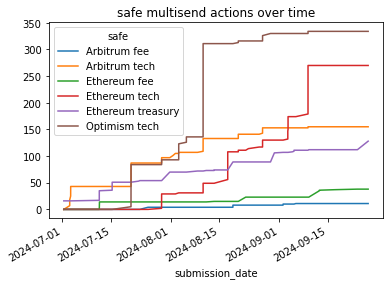

In [10]:
df = pd.DataFrame(txs_with_multisends)
df = df[df.submission_date >= '2024-07-01']
df = df[df.submission_date < '2024-10-01']
print(df.multisend.sum(), len(df), df.fee.fillna(0).sum())
df = df.pivot_table(['nonce', 'multisend', 'fee'], 'submission_date', 'safe')
df['multisend'] = df.multisend.fillna(0).cumsum()
df['nonce'] = df.nonce.fillna(method='bfill')
df['fee'] = df.fee.fillna(0).cumsum()

df['multisend'].plot(title='safe multisend actions over time')
# plt.savefig('yearn-safes-multisend.png', dpi=300, facecolor='w')

In [20]:
for safe in safe_txs:
    print( safe )
    df = pd.DataFrame(get_confirmations(safe_txs[safe]))
    #df['owner'] = df['owner'].apply(owner_map.get)
    if (len(df.index) > 0):
        df = df[df.is_executed]
        df = df[df.submission_date >= '2024-07-01']
        df = df[df.submission_date < '2024-10-01']
        total = len(df.nonce.unique())
        print( (df.groupby('owner').count().sort_values('nonce', ascending=False)).nonce )
    else:
        print( "no txs")

Ethereum tech
owner
0x225C529a6a84AE9E45F97B6692E387791c3Ee8E8    35
0x8cC8c75013D561Ad81D7d08591836Fc78585aE34    34
0xb9b7Db94D57fe25907620eAae42b9780176CceeA    34
0xFd660518dC1b52d9F67FAcd42bbBA962B06b8E54    33
0xf33Ea4EE285B5DAC9a6163d8939699d59a7199BA    26
0xA0BaCE512E2904ccFDD24AB56feea6621ce14613    20
0x198c4D019BefE68415351E2C0F9b05585cfAAa5b    17
0xb195a8CF4898E6DDc92e435cb118E9842456A45A     7
0x0Cec743b8CE4Ef8802cAc0e5df18a180ed8402A7     4
Name: nonce, dtype: int64
Ethereum treasury
owner
0xf3D476566BCC8E882A3910F1471428522449d89E    19
0xAa163c47065c22D17Ed1c47E3E244337D2056c17    18
0xC16C60fcDe4c2D4B4C53bE2680602d6938aC9eC9    18
0x6D526f6b4C86FBdc8e359e6bef4Cd6a42aceA2d7    17
0x23e85dB353bFDa25329c4e12b98Aa991F541eA2d    13
0x84641137BaC4Db68DE94Ec3D2ED89acE0AA88f20     5
0xD4a53DfC19Df4C950428db1532cba2223fb3a752     3
0x585d9e95871C82eEC89c906C9eb1f562078aE969     1
0x786A4Eb282a6332871e4BaD890cE5960f1d12813     1
Name: nonce, dtype: int64
Ethereum fee
owner
0xA